In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec9_graphs as afx

plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('ggplot')
df = pd.read_csv('spamdata_esl_colnames.csv').drop(columns='Unnamed: 0')

In [4]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
print(df['spam'].value_counts('%'))

0    0.605955
1    0.394045
Name: spam, dtype: float64


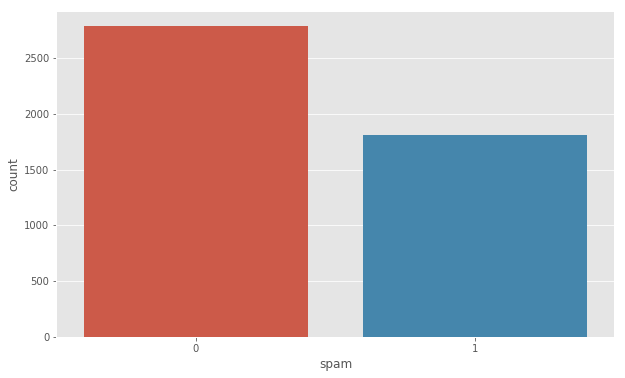

In [6]:
sns.countplot(df['spam'])

In [7]:
exclude_df = df.filter(regex='word_freq_*')
exclude_df['spam'] = df['spam']
store_means_no_spam = exclude_df.query('spam == 0').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)
store_means_spam = exclude_df.query('spam == 1').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)

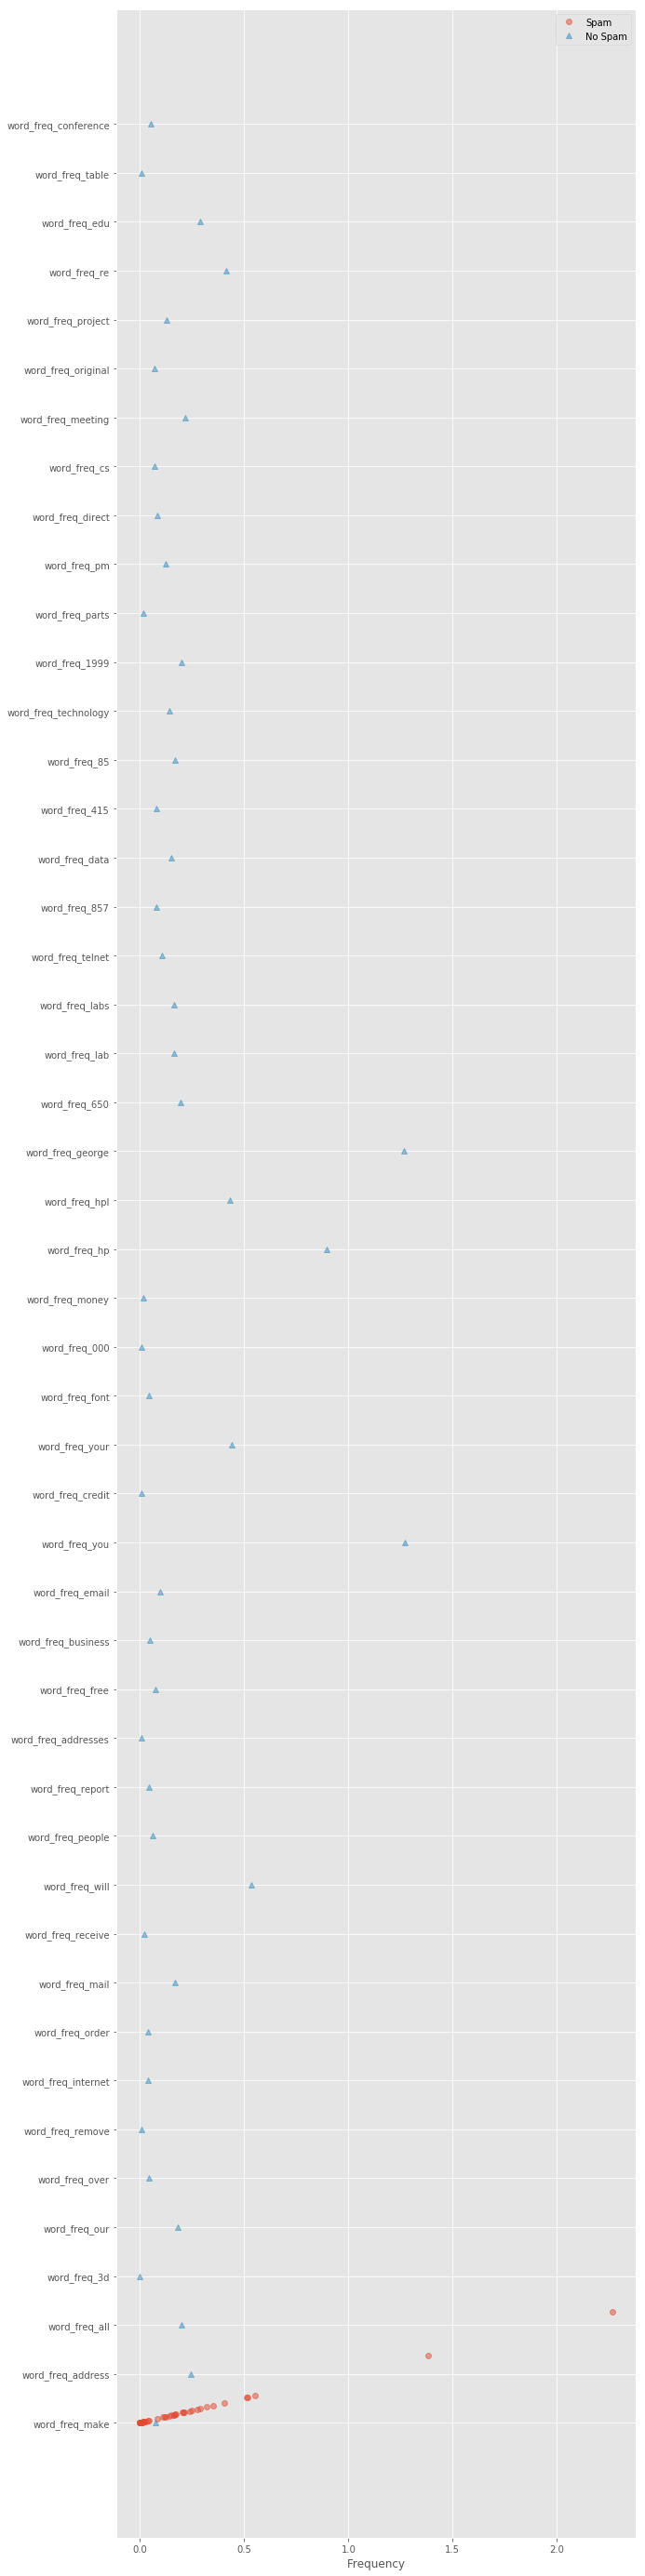

In [8]:
plt.figure(figsize=(10,50))
plt.plot(store_means_spam, store_means_spam.values, 'o', alpha=.5,label='Spam')
plt.plot(store_means_no_spam, store_means_no_spam.index,'^',alpha=.5, label='No Spam')
plt.xlabel('Frequency')
plt.legend()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [18]:
X_train , X_test , y_train , y_test = train_test_split(df.loc[:,'word_freq_make':'capital_run_length_total'],
                                                       df['spam'], test_size=.33 , random_state=11238)

In [20]:
decision_stump = DecisionTreeClassifier(max_depth=1,random_state=11238).fit(X_train,y_train)

adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                        random_state=11238).fit(X_train,y_train)

In [21]:
tree_y_hat = decision_stump.predict(X_test)
adaboost_y_hat = adaboost_classifier.predict(X_test)
adaboost_pr = adaboost_classifier.predict_proba(X_test)

In [22]:
print('Decision Stump:')
print(classification_report(y_test, tree_y_hat, digits=3))
print('Adaboost class')
print('cantidad estimadores' , adaboost_classifier.n_estimators)
print(classification_report(y_test, adaboost_y_hat, digits=3))

Decision Stump:
              precision    recall  f1-score   support

           0      0.844     0.793     0.817       912
           1      0.715     0.779     0.745       607

   micro avg      0.787     0.787     0.787      1519
   macro avg      0.779     0.786     0.781      1519
weighted avg      0.792     0.787     0.789      1519

Adaboost class
cantidad estimadores 50
              precision    recall  f1-score   support

           0      0.939     0.950     0.944       912
           1      0.923     0.908     0.915       607

   micro avg      0.933     0.933     0.933      1519
   macro avg      0.931     0.929     0.930      1519
weighted avg      0.933     0.933     0.933      1519



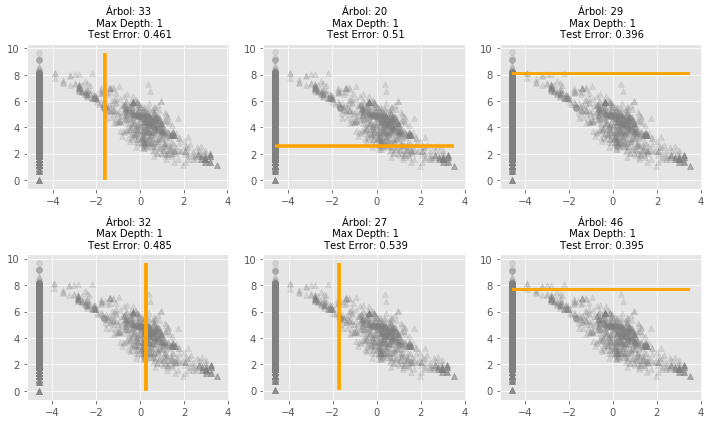

In [25]:
afx.adaboost_weak_learner_behavior()

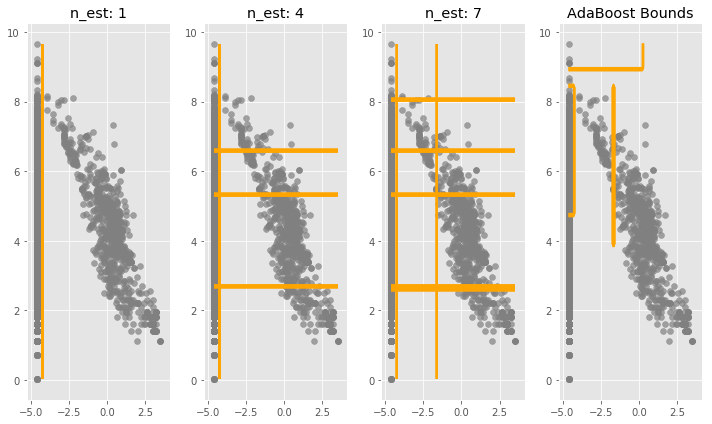

In [26]:
afx.adaboost_adaptive_behavior()

In [27]:
store_pr = []

for i in adaboost_classifier.staged_predict_proba(X_test):
    store_pr.append(i)

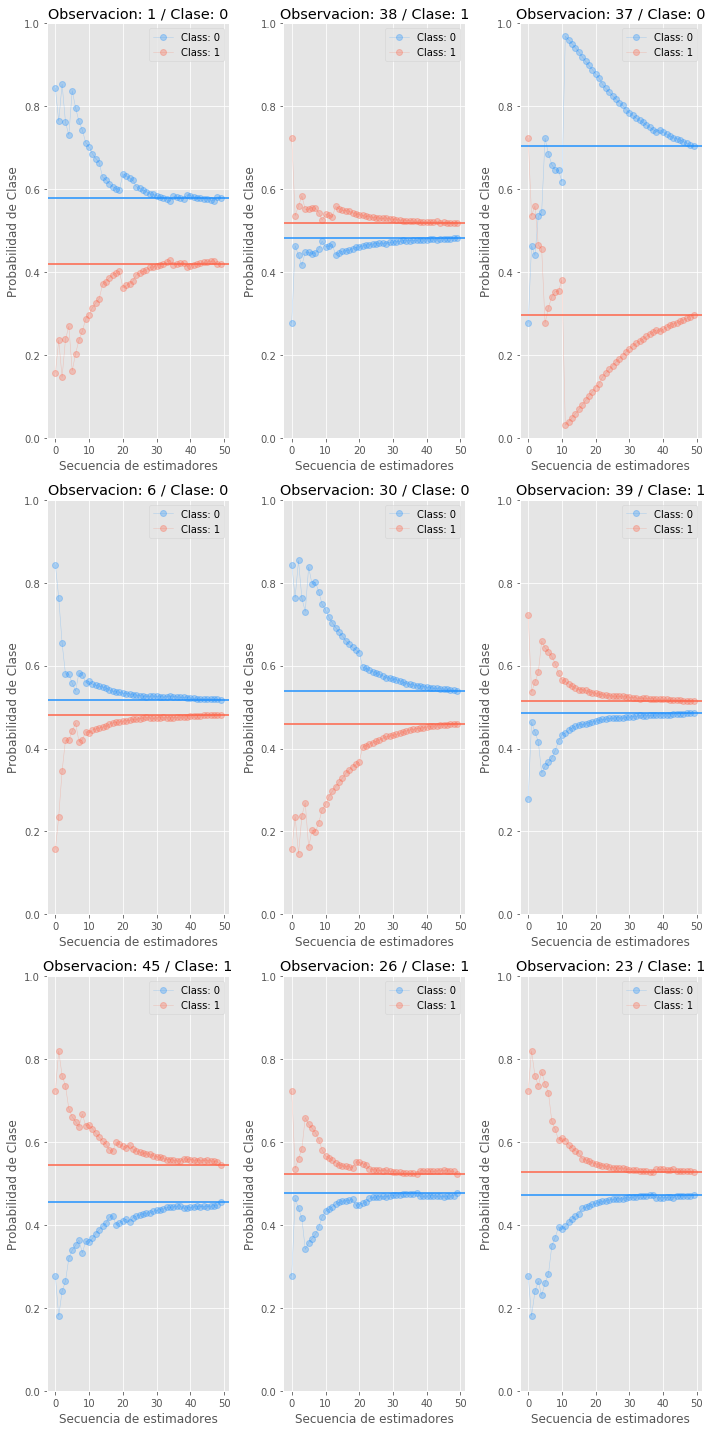

In [28]:
plt.figure(figsize=(10,20))

np.random.seed(11238)

for index,value in enumerate(np.random.randint(1,50, size=9)):
    plt.subplot(3,3, index+1)
    mlc = afx.adaboost_classification_behavior(store_pr, adaboost_pr, value)
    plt.title(f'Observacion: {value} / Clase: {mlc}')
    plt.ylim((0,1))
    plt.ylabel('Probabilidad de Clase')
    plt.xlabel('Secuencia de estimadores')
    plt.tight_layout()

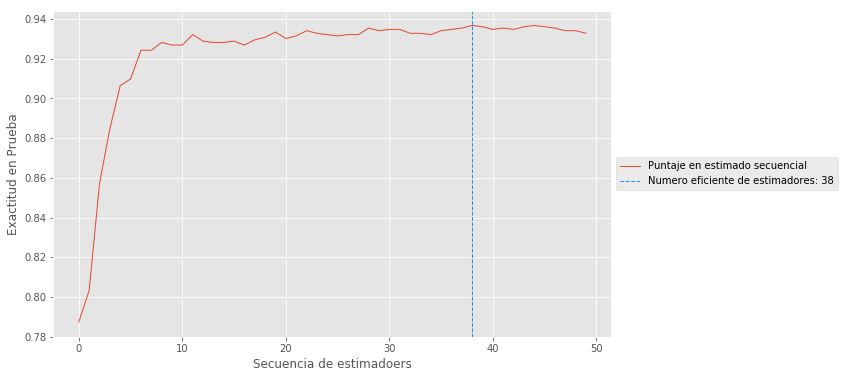

In [34]:
store_acc = np.empty(adaboost_classifier.n_estimators)
for index , value in enumerate(adaboost_classifier.staged_score(X_test,y_test)):
        store_acc[index] = value
        
signal_optim = np.where(store_acc == np.max(store_acc))[0][0]

plt.plot(store_acc,'-', lw=1, label='Puntaje en estimado secuencial')
plt.axvline(signal_optim, color='dodgerblue', lw=1,linestyle='--', label=f'Numero eficiente de estimadores: {signal_optim}')
plt.xlabel('Secuencia de estimadoers')
plt.ylabel('Exactitud en Prueba')
plt.legend(loc='center left', bbox_to_anchor=(1,.5))


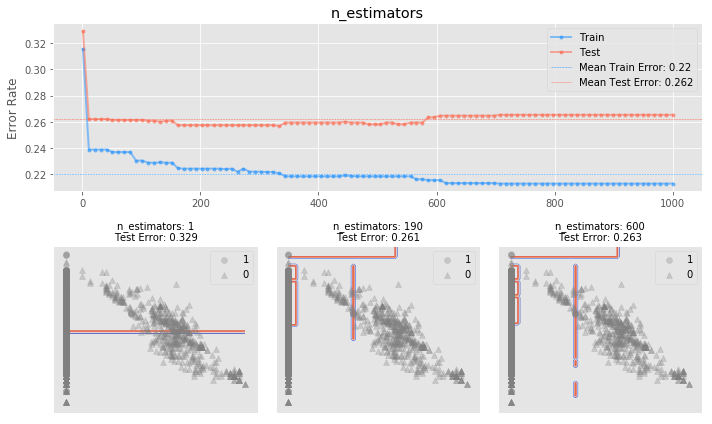

In [36]:
afx.n_estimators_hyperparams()

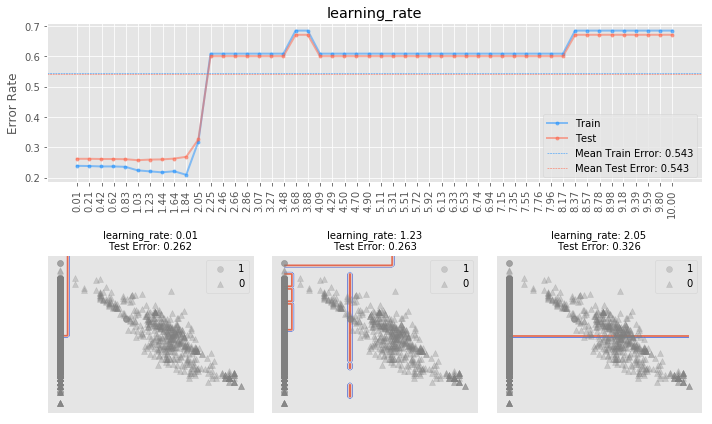

In [37]:
afx.learning_rate_hyperparams()

In [39]:
from sklearn.ensemble import RandomForestClassifier

tree_decision_stump = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
rf_model = RandomForestClassifier(max_depth=1).fit(X_train,y_train)
adaboost = AdaBoostClassifier(random_state=11238).fit(X_train,y_train)

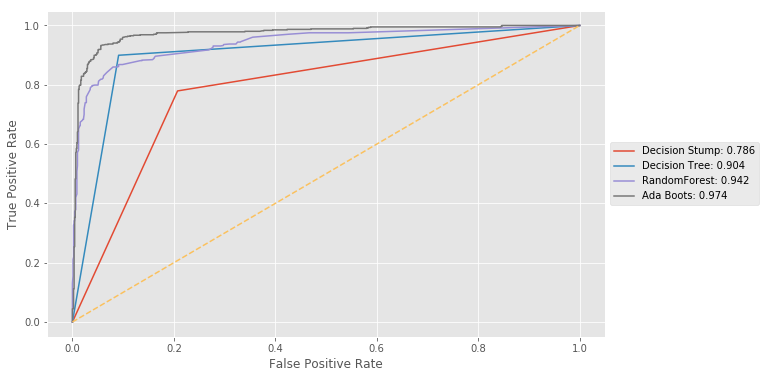

In [43]:
afx.plot_roc(model=tree_decision_stump,y_true=y_test, X_test=X_test, model_label='Decision Stump')
afx.plot_roc(model=tree_model,y_true=y_test,X_test= X_test, model_label='Decision Tree')
afx.plot_roc(model=rf_model,y_true=y_test,X_test= X_test, model_label='RandomForest')
afx.plot_roc(model=adaboost,y_true=y_test,X_test= X_test, model_label='Ada Boots')
plt.plot([0,1], ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1,.5))

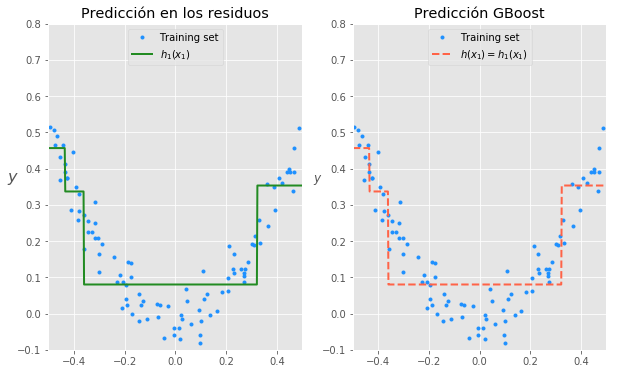

In [44]:
afx.gboost_stage_one()

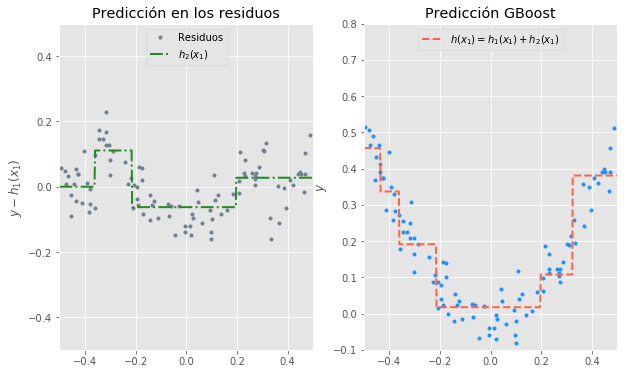

In [45]:
afx.gboost_stage_two()

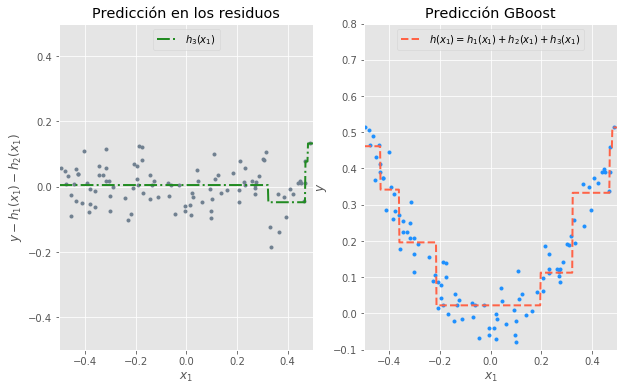

In [46]:
afx.gboost_stage_three()

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
gradient_boost_model = GradientBoostingClassifier().fit(X_train,y_train)
y_hat = gradient_boost_model.predict(X_test)
print(classification_report(y_test,y_hat, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.961     0.958       912
           1      0.940     0.932     0.936       607

   micro avg      0.949     0.949     0.949      1519
   macro avg      0.948     0.946     0.947      1519
weighted avg      0.949     0.949     0.949      1519



In [50]:
gradient_boost_model.estimators_[0][0] #mediando un arbol de regresion, sep uede obtener una metrica entre lo predicho a lo real

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000001A089715120>,
           splitter='best')

In [51]:
print(type(gradient_boost_model.loss_))

<class 'sklearn.ensemble.gradient_boosting.BinomialDeviance'>


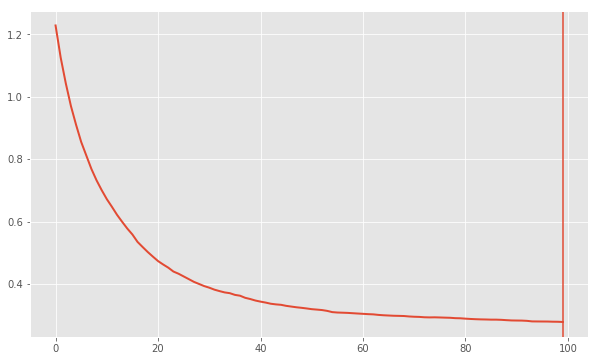

In [52]:
gb_loss_1 , optim = afx.profile_loss_function(gradient_boost_model, X_test,y_test)
plt.plot(gb_loss_1, label='Benchmark Gboost', lw=2)
plt.axvline(optim, label='optim N trees')

In [53]:
print('Exactitud en testing: ', gradient_boost_model.score(X_test,y_test).round(3))
print('Exactitud en training: ', gradient_boost_model.score(X_train, y_train).round(3))

Exactitud en testing:  0.949
Exactitud en training:  0.964


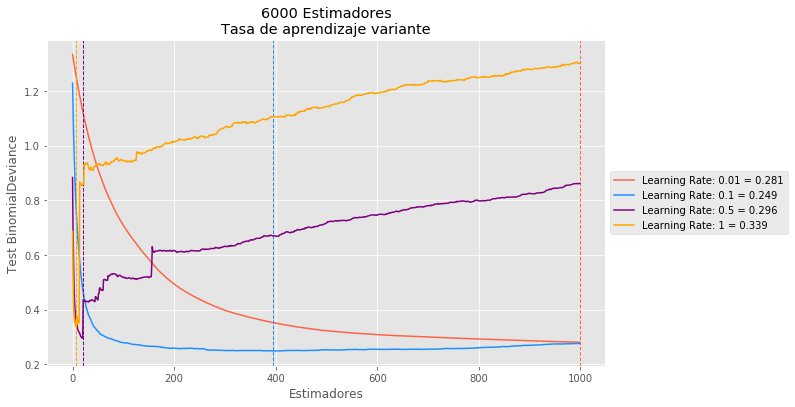

In [54]:
afx.gboost_learning_hyperparams(X_train,X_test,y_train, y_test)

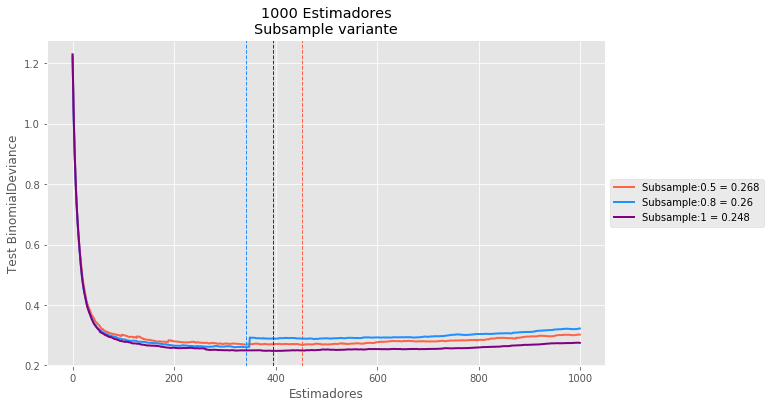

In [55]:
afx.gboost_sampling_hyperparams(X_train,X_test,y_train,y_test)

In [56]:
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid = {'n_estimators': [100,500,1000],
             'learning_rate': [0.01 , 0.1 , 0.5 , 1, 5, 10],
             'subsample': np.linspace(0.1, 1.0 ,5, endpoint=True, dtype=float)}

In [59]:
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train,y_train)

In [62]:
y_hat = gb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       912
           1       0.94      0.94      0.94       607

   micro avg       0.95      0.95      0.95      1519
   macro avg       0.95      0.95      0.95      1519
weighted avg       0.95      0.95      0.95      1519



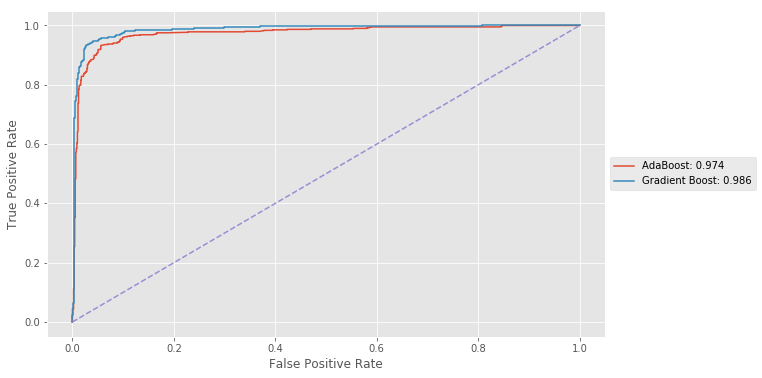

In [61]:
afx.plot_roc(model=adaboost_classifier,y_true=y_test, X_test=X_test, model_label='AdaBoost')
afx.plot_roc(model=gb_grid.best_estimator_,y_true=y_test,X_test= X_test, model_label='Gradient Boost')
plt.plot([0,1], ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1,.5))